In [1]:
import numpy as np
import seaborn as sns
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mplc

In [2]:
!pip install geopandas

In [3]:
data = pd.read_csv("Projet_Methane.csv", sep=",")
data.head()

,region,country,emissions,type,segment,reason
0,Africa,Algeria,257.611206,Agriculture,Total,All
1,Africa,Algeria,0.052000,Energy,Bioenergy,All
2,Africa,Algeria,130.798996,Energy,Gas pipelines and LNG facilities,Fugitive
3,Africa,Algeria,69.741898,Energy,Gas pipelines and LNG facilities,Vented
4,Africa,Algeria,213.987000,Energy,Onshore gas,Fugitive


In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world['name'] = world['name'].replace('United States of America', 'United States')
world['continent'] = world['continent'].replace('South America', 'Central and South America')
world['continent'] = world['continent'].replace('Asia', 'Asia Pacific')

world

<ipython-input-4-b9286759f397>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [5]:
merged2_data = world.merge(data,  left_on='continent', right_on='region')
merged2_data

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,region,country,emissions,type,segment,reason
0,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Algeria,257.611206,Agriculture,Total,All
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Algeria,0.052000,Energy,Bioenergy,All
2,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Algeria,130.798996,Energy,Gas pipelines and LNG facilities,Fugitive
3,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Algeria,69.741898,Energy,Gas pipelines and LNG facilities,Vented
4,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Algeria,213.987000,Energy,Onshore gas,Fugitive
...,...,...,...,...,...,...,...,...,...,...,...,...
48646,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",Europe,United Kingdom,30.171593,Energy,Other from oil and gas,All
48647,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",Europe,United Kingdom,9.205160,Energy,Steam coal,All
48648,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",Europe,United Kingdom,274.631409,Energy,Total,All
48649,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",Europe,United Kingdom,64.704193,Other,Total,All


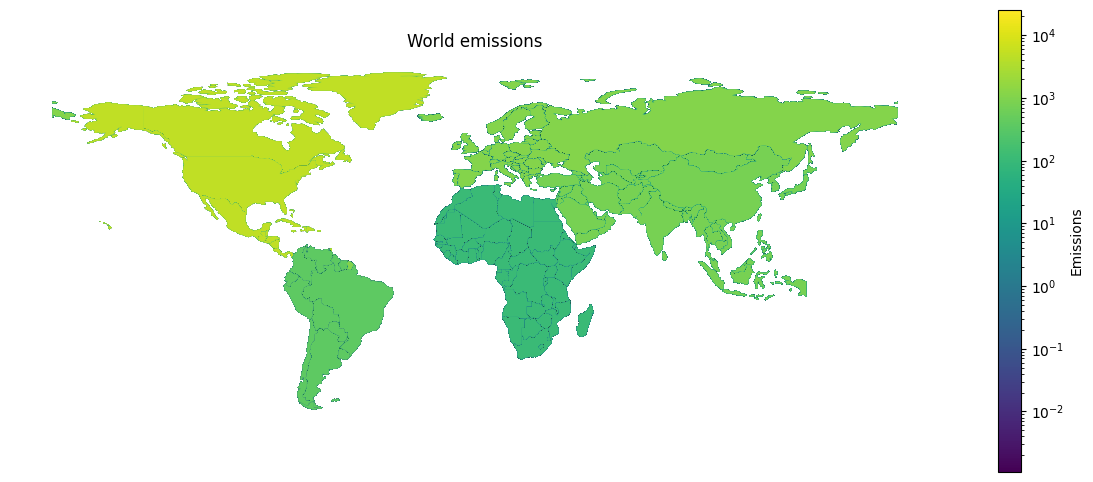

In [18]:
ax = merged2_data.plot(
    column="emissions", cmap="viridis", legend=True,
    legend_kwds={'label': 'Emissions'}, figsize=(15, 6),
    norm=mplc.LogNorm(vmin=merged2_data['emissions'].min(), vmax=merged2_data['emissions'].max())
)
ax.set_title("World emissions")
ax.axis(False)
plt.savefig("emission_by_region.png")

In [7]:
merged3_data = world.merge(data,  left_on='name', right_on='country')
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['pop_est', 'continent', 'name','iso_a3','gdp_md_est']
# Supprimer les colonnes spécifiées
merged3_data = merged3_data.drop(colonnes_a_supprimer, axis=1)
merged3_data

,geometry,region,country,emissions,type,segment,reason
0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Tanzania,1180.221924,Agriculture,Total,All
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Tanzania,192.063995,Energy,Bioenergy,All
2,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Tanzania,2.064310,Energy,Gas pipelines and LNG facilities,Fugitive
3,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Tanzania,1.100690,Energy,Gas pipelines and LNG facilities,Vented
4,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Africa,Tanzania,0.712062,Energy,Offshore gas,Fugitive
...,...,...,...,...,...,...,...
1326,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Central and South America,Trinidad and Tobago,12.492500,Energy,Onshore oil,Vented
1327,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Central and South America,Trinidad and Tobago,0.921282,Energy,Other from oil and gas,All
1328,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Central and South America,Trinidad and Tobago,209.220001,Energy,Total,All
1329,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Central and South America,Trinidad and Tobago,5.858375,Other,Total,All


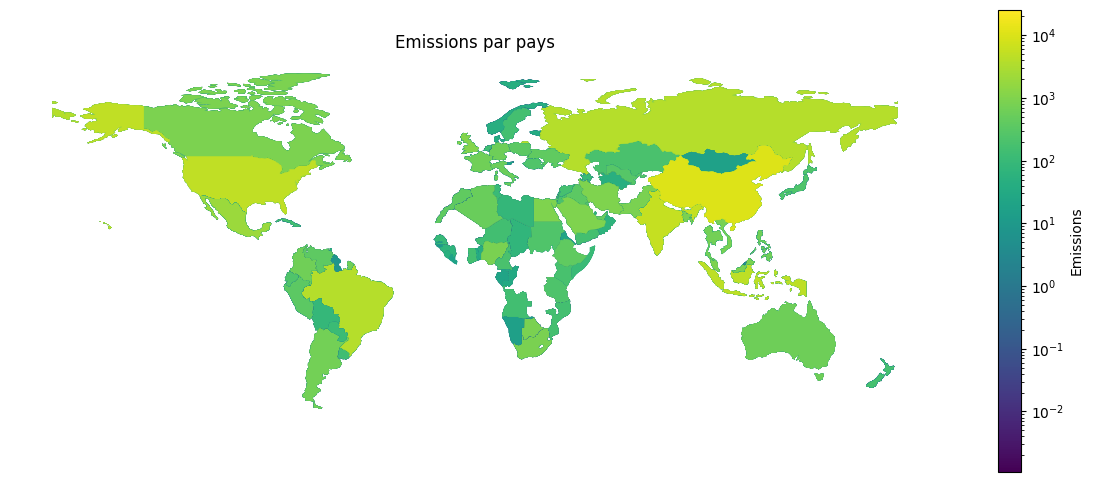

In [19]:
ax = merged3_data.plot(
    column="emissions", cmap="viridis", legend=True,
    legend_kwds={'label': 'Emissions'}, figsize=(15, 6),
    norm=mplc.LogNorm(vmin=merged3_data['emissions'].min(), vmax=merged3_data['emissions'].max())
)
ax.set_title("Emissions par pays")
ax.axis(False)
plt.savefig("emission_pays.png")

In [9]:
print(data.country.unique())
print(data["country"].nunique())

['Algeria' 'Angola' 'Benin' 'Botswana' 'Cameroon'
 'Central African Republic' 'Chad' 'Congo' "Cote d'Ivoire"
 'Democratic Republic of Congo' 'Egypt' 'Equatorial Guinea' 'Eritrea'
 'Ethiopia' 'Gabon' 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Kenya'
 'Liberia' 'Libya' 'Morocco' 'Mozambique' 'Namibia' 'Niger' 'Nigeria'
 'Senegal' 'Seychelles' 'Sierra Leone' 'Somalia' 'South Africa'
 'South Sudan' 'Sudan' 'Tanzania' 'Togo' 'Tunisia' 'Australia'
 'Bangladesh' 'Brunei' 'China' 'India' 'Indonesia' 'Japan' 'Korea'
 'Malaysia' 'Mongolia' 'New Zealand' 'Other countries in Southeast Asia'
 'Pakistan' 'Philippines' 'Thailand' 'Vietnam' 'Argentina' 'Bolivia'
 'Brazil' 'Colombia' 'Cuba' 'Ecuador' 'Guyana' 'Paraguay' 'Peru'
 'Trinidad and Tobago' 'Uruguay' 'Venezuela' 'Denmark' 'Estonia'
 'European Union' 'France' 'Germany' 'Israel' 'Italy' 'Netherlands'
 'Norway' 'Other countries in Europe' 'Other EU17 countries'
 'Other EU7 countries' 'Poland' 'Romania' 'Slovenia' 'Sweden' 'Ukraine'
 'United Kingd

In [10]:
a=data[data['region']=='Europe'] #pays de l'Europe
print(a.country.unique()) # pays unique dans l'Europe
print(a["country"].nunique()) #nombre de pays en Europe

['Denmark' 'Estonia' 'European Union' 'France' 'Germany' 'Israel' 'Italy'
 'Netherlands' 'Norway' 'Other countries in Europe' 'Other EU17 countries'
 'Other EU7 countries' 'Poland' 'Romania' 'Slovenia' 'Sweden' 'Ukraine'
 'United Kingdom']
18


In [11]:
#émissions des pays d'Europe:
e=data[data['region']=='Europe']['emissions']
e

859      240.093613
860       18.736000
861        2.726220
862        1.453620
863        0.902012
           ...     
1156      30.171593
1157       9.205160
1158     274.631409
1159      64.704193
1160    1113.141235
Name: emissions, Length: 302, dtype: float64

In [12]:
gb=data.groupby('region')
moy=gb.mean() #émission moyenne par continent
moy

<ipython-input-12-59cf67f22cd7>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  moy=gb.mean() #émission moyenne par continent


,emissions
region,
Africa,133.490524
Asia Pacific,658.146709
Central and South America,249.398851
Europe,162.943698
Middle East,203.720849
North America,1038.482118
Other,761.778913
Russia & Caspian,650.225129
World,22234.196225


In [13]:
moy = moy[moy.index != 'world']
regions = moy.index
moyennes = moy['emissions']
moyennes

region
Africa                         133.490524
Asia Pacific                   658.146709
Central and South America      249.398851
Europe                         162.943698
Middle East                    203.720849
North America                 1038.482118
Other                          761.778913
Russia & Caspian               650.225129
World                        22234.196225
Name: emissions, dtype: float64

In [14]:
import plotly.express as px
filtered_data = data[data['region'] != 'World']
filtered_data2 = filtered_data[filtered_data['segment'] == 'Total']

# Ensuite, vous pouvez faire la somme des émissions par pays
sum_by_country = filtered_data2.groupby(['region', 'country'])['emissions'].sum().reset_index()
sum_by_country

,region,country,emissions
0,Africa,Algeria,3444.247114
1,Africa,Angola,1202.906883
2,Africa,Benin,217.674686
3,Africa,Botswana,949.096299
4,Africa,Cameroon,714.549126
...,...,...,...
99,Russia & Caspian,Azerbaijan,623.687966
100,Russia & Caspian,Kazakhstan,3719.001436
101,Russia & Caspian,Russia,24354.845947
102,Russia & Caspian,Turkmenistan,5094.357394


In [20]:
import plotly.express as px
filtered_data = data[data['region'] != 'World']
filtered_data2 = filtered_data[filtered_data['segment'] == 'Total']

# Ensuite, vous pouvez faire la somme des émissions par pays
sum_by_country = filtered_data2.groupby(['region', 'country'])['emissions'].sum().reset_index()

# Créer un graphique à barres interactif avec Plotly Express
fig = px.bar(sum_by_country, x='region', y='emissions', color='country',
             labels={'emissions': 'Émissions', 'region': 'Région'},
             title='Émissions par pays dans chaque région',
             height=500, width=1000)

# Afficher le graphique interactif
fig.show()
plt.savefig("emissions_barplot.png")

<Figure size 640x480 with 0 Axes>

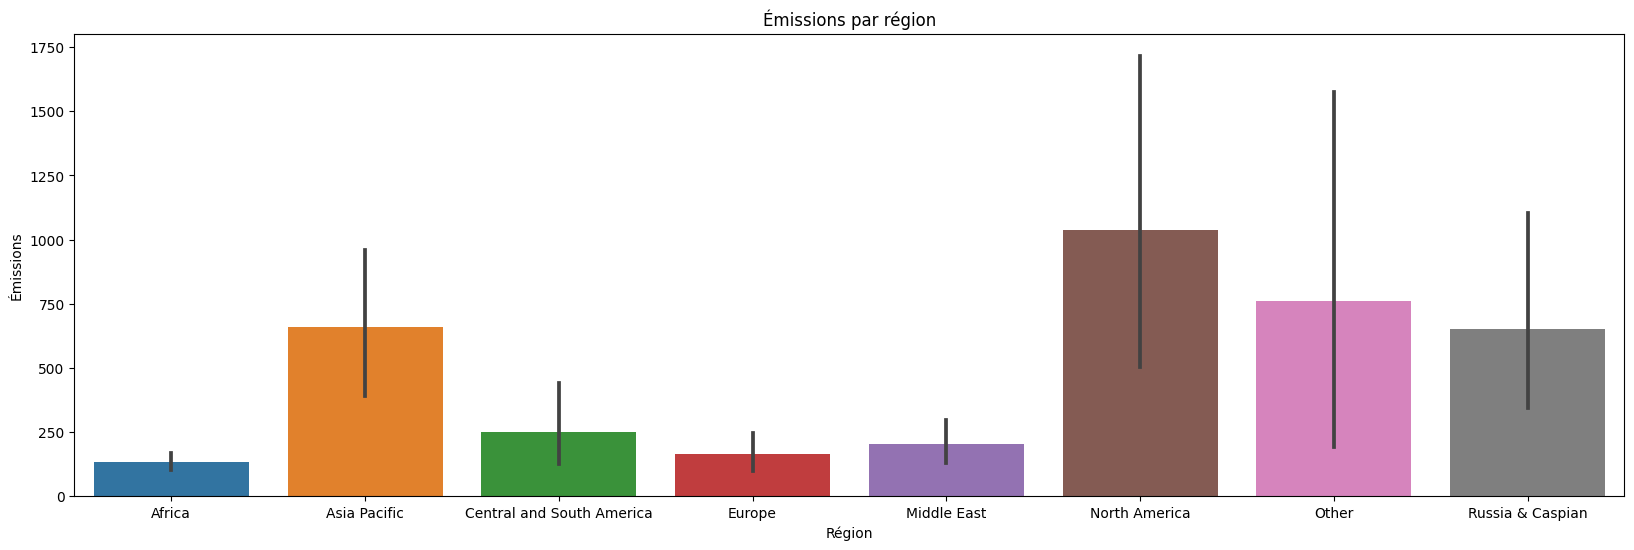

In [16]:
filtered_data = data[data['region'] != 'World']
plt.figure(figsize=(20, 6))
sns.barplot(x='region', y='emissions', data=filtered_data)
plt.xlabel('Région')
plt.ylabel('Émissions')
plt.title('Émissions par région')
plt.show()

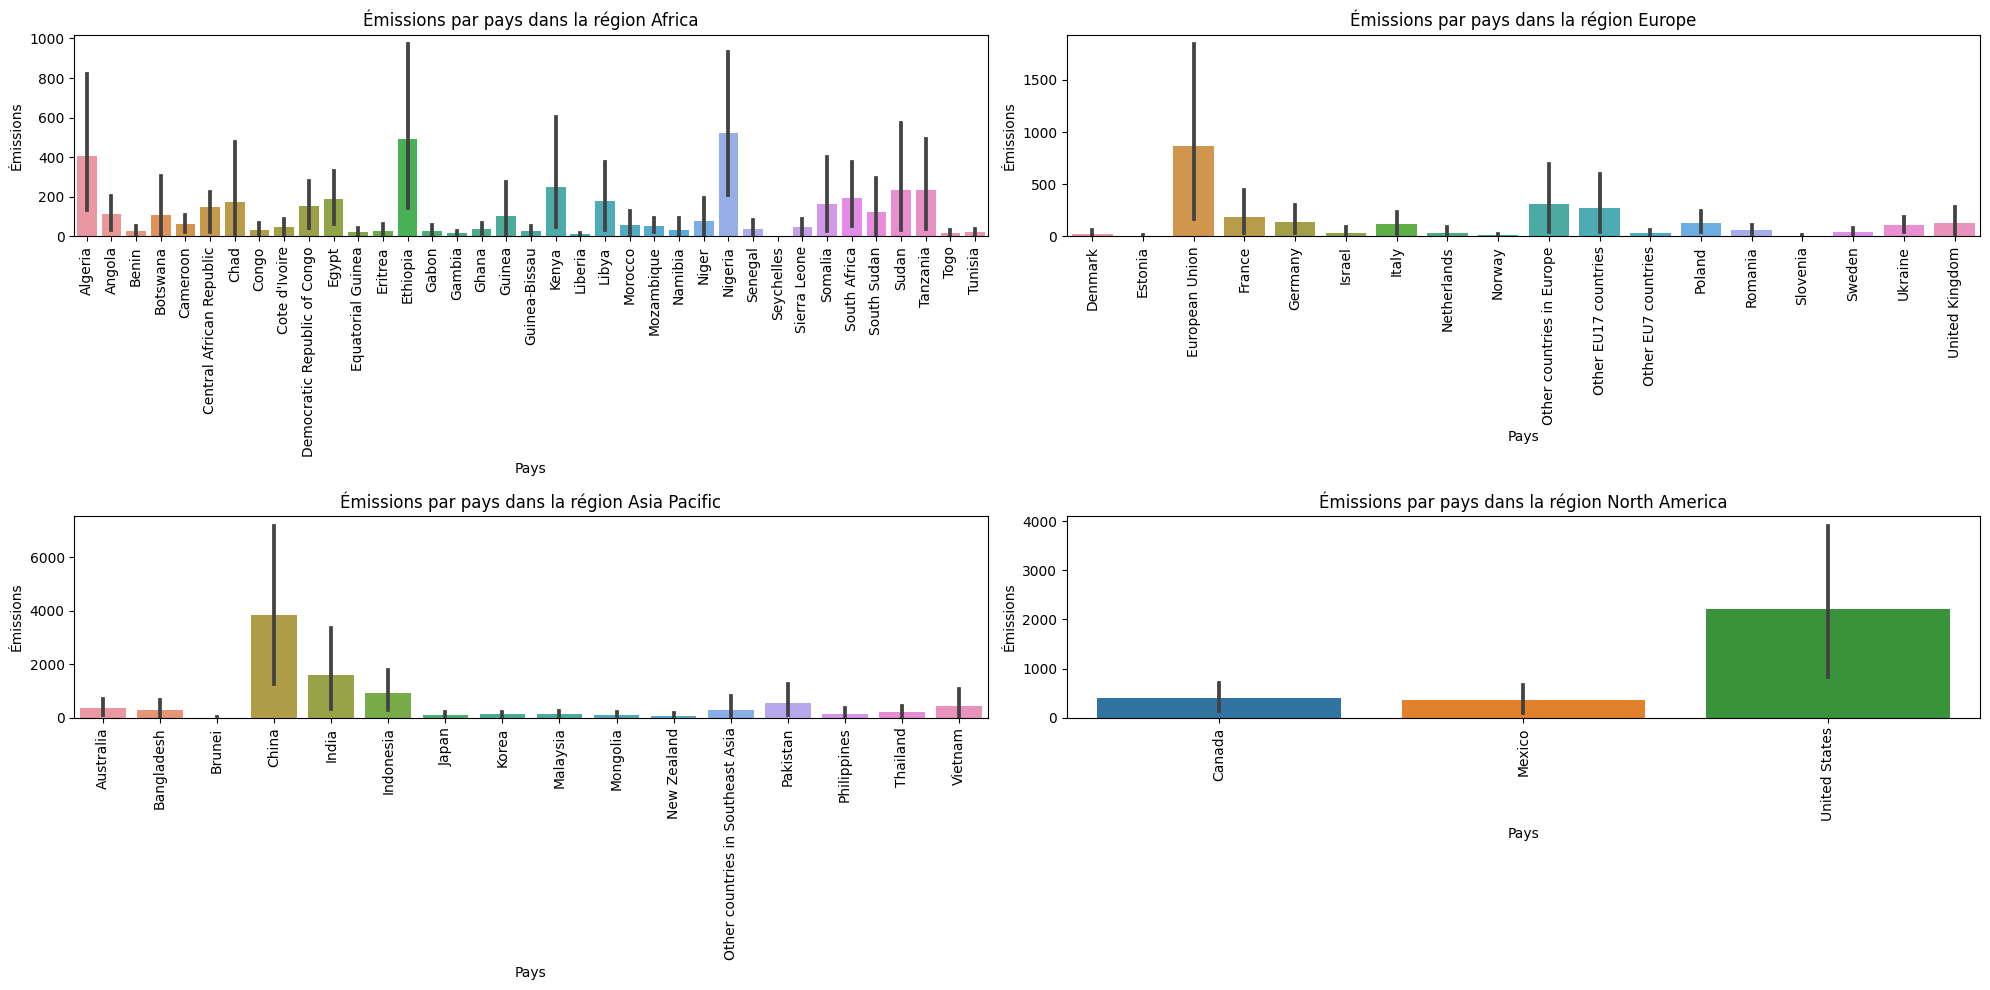

In [17]:
# Régions spécifiques que vous voulez afficher
selected_regions = ['Africa', 'Europe', 'Asia Pacific', 'North America']  # Remplacez par les noms de vos régions

# Création des sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(20, 10))  # 2 lignes, 2 colonnes pour 4 graphiques

# Parcourir les régions sélectionnées et créer un graphique pour chacune
for i, region in enumerate(selected_regions):
    row = i // 2  # Ligne du sous-graphique
    col = i % 2   # Colonne du sous-graphique

    # Filtrer les données pour la région spécifique
    region_data = data[data['region'] == region]

    # Créer le graphique à barres pour les émissions par pays dans la région spécifique
    sns.barplot(x='country', y='emissions', data=region_data, ax=axes[row, col])
    axes[row, col].set_title(f'Émissions par pays dans la région {region}')
    axes[row, col].set_xlabel('Pays')
    axes[row, col].set_ylabel('Émissions')
    axes[row, col].tick_params(axis='x', rotation=90)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()